# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

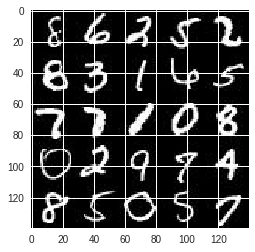

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

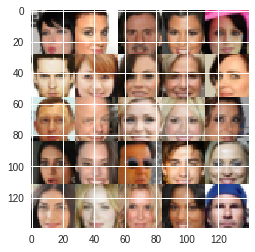

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out

    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    input_real, input_z, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 20
    show_every = 200
    losses = []
    n_images = 16
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={
                        input_real: batch_images, input_z: z_sample, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={
                        input_z: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: z_sample, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images,input_z, img_channels, data_image_mode)
                        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.0072... Generator Loss: 0.0516
Epoch 1/2... Discriminator Loss: 0.4555... Generator Loss: 2.7591
Epoch 1/2... Discriminator Loss: 0.5103... Generator Loss: 1.3854
Epoch 1/2... Discriminator Loss: 0.1405... Generator Loss: 3.1532
Epoch 1/2... Discriminator Loss: 0.1801... Generator Loss: 4.0805
Epoch 1/2... Discriminator Loss: 0.2249... Generator Loss: 2.4927
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 7.7750
Epoch 1/2... Discriminator Loss: 0.7309... Generator Loss: 1.0034
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 0.2378... Generator Loss: 2.0292


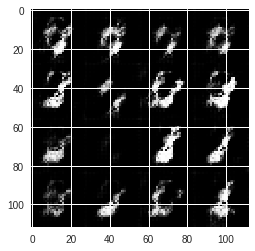

Epoch 1/2... Discriminator Loss: 0.1880... Generator Loss: 3.2694
Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 1.2643
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 0.5546... Generator Loss: 1.5091
Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 1.6889
Epoch 1/2... Discriminator Loss: 1.3475... Generator Loss: 6.4908
Epoch 1/2... Discriminator Loss: 0.5646... Generator Loss: 3.6372
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 3.7133
Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 1.1884
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 0.8260


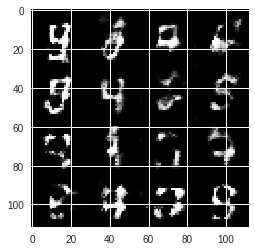

Epoch 1/2... Discriminator Loss: 0.4997... Generator Loss: 2.5392
Epoch 1/2... Discriminator Loss: 0.7680... Generator Loss: 1.2625
Epoch 1/2... Discriminator Loss: 0.9223... Generator Loss: 2.3084
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 3.0240
Epoch 1/2... Discriminator Loss: 0.6262... Generator Loss: 1.6669
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 0.6030
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 1.5196
Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 1.1502
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.5671


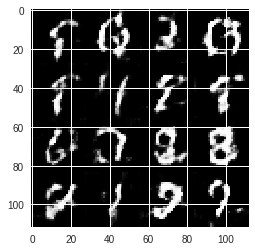

Epoch 1/2... Discriminator Loss: 0.6697... Generator Loss: 2.0342
Epoch 1/2... Discriminator Loss: 1.5284... Generator Loss: 2.7053
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 0.4994
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 1.6049
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.1782
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 1.6816
Epoch 1/2... Discriminator Loss: 0.5693... Generator Loss: 1.4536
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.4138


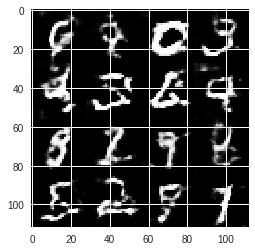

Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 2.0850
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.4079
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.1209
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 1.2443
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 0.9640
Epoch 2/2... Discriminator Loss: 0.8251... Generator Loss: 1.1916
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 1.0764
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.3505
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.5730


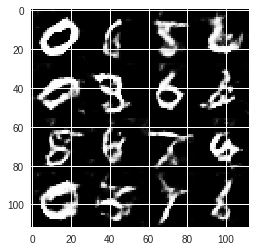

Epoch 2/2... Discriminator Loss: 2.6106... Generator Loss: 0.1064
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 0.9950
Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.1046
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 1.8333
Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 1.3749
Epoch 2/2... Discriminator Loss: 0.5986... Generator Loss: 1.3376
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 1.5758
Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.4828


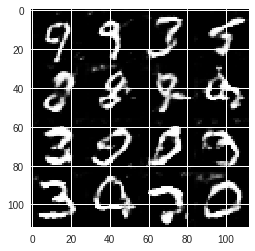

Epoch 2/2... Discriminator Loss: 1.9236... Generator Loss: 0.2909
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 0.8649
Epoch 2/2... Discriminator Loss: 0.9127... Generator Loss: 0.8430
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 1.2774
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 0.6468
Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 0.4653
Epoch 2/2... Discriminator Loss: 1.1063... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 0.9873
Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 0.5872


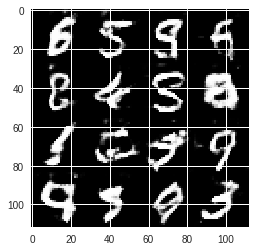

Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 1.8161
Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 0.4716
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 2.3161
Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 0.6471
Epoch 2/2... Discriminator Loss: 2.0178... Generator Loss: 0.2362
Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.2655
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 1.3781


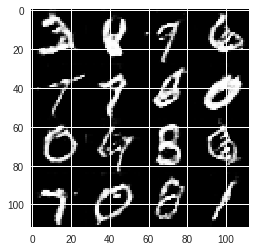

Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 2.3273
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 0.9585
Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 1.1000
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 2.6614
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 0.5686... Generator Loss: 1.4056
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 1.1679
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 2.3166


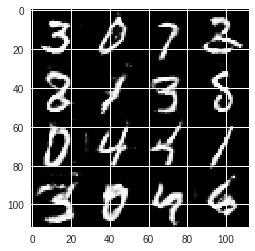

Epoch 2/2... Discriminator Loss: 0.6547... Generator Loss: 1.1788
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 1.5481... Generator Loss: 0.4444


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3663... Generator Loss: 12.1934
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 11.4552
Epoch 1/1... Discriminator Loss: 7.2311... Generator Loss: 0.0212
Epoch 1/1... Discriminator Loss: 0.2359... Generator Loss: 2.6751
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 5.4039
Epoch 1/1... Discriminator Loss: 0.1153... Generator Loss: 4.7494
Epoch 1/1... Discriminator Loss: 0.2202... Generator Loss: 2.3819
Epoch 1/1... Discriminator Loss: 0.2590... Generator Loss: 2.2387
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.6295


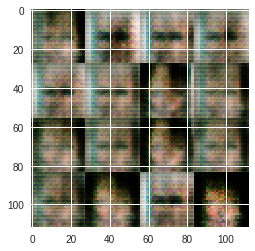

Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.8945
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 2.4750... Generator Loss: 2.2703
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.7783... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 2.3300
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 1.3816


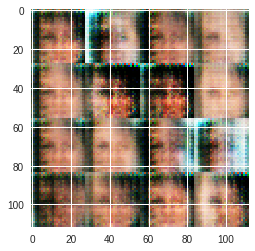

Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 1.8685
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.2073
Epoch 1/1... Discriminator Loss: 1.6345... Generator Loss: 3.7762
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 2.3022
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.7100... Generator Loss: 2.9910
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.6188


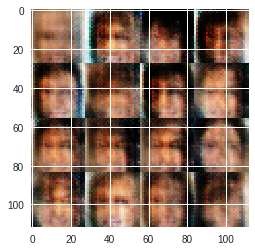

Epoch 1/1... Discriminator Loss: 3.4775... Generator Loss: 3.6353
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.7356
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.8161
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.4125
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.3030


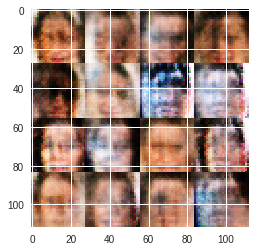

Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.9329
Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.3935
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 1.9611... Generator Loss: 0.2671


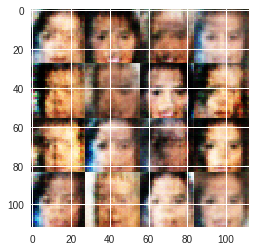

Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 2.1569
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 1.8962... Generator Loss: 3.0119
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.7725... Generator Loss: 2.7248
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.9798


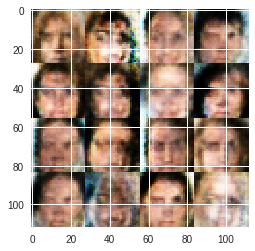

Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 2.3044
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.5382
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.5711
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.1547


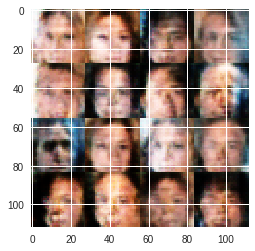

Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.6874
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.2408


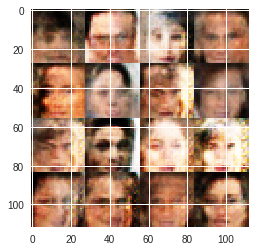

Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.6125
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 2.0396
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.6653


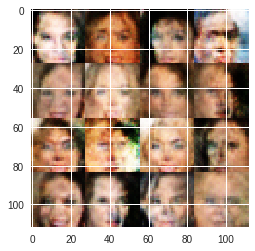

Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 1.3587
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.5308
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.3326
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.6461... Generator Loss: 0.6375


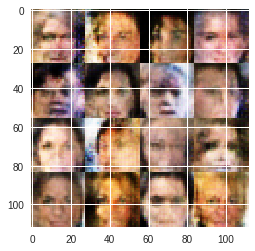

Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 2.0180... Generator Loss: 0.2518
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.5881


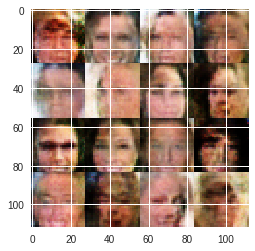

Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 1.7861
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.3810
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.7795


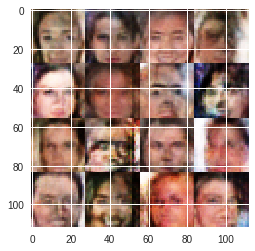

Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.6553
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.4384
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.3339
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.5275
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 1.0702


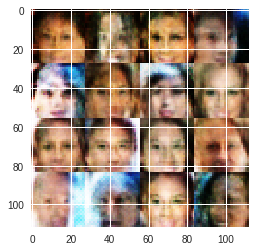

Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.3155
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.9207
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.3597
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.3550


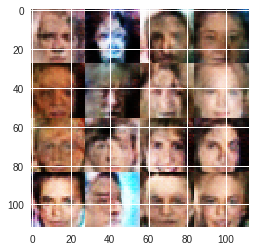

Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 0.6532... Generator Loss: 1.9872
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.5389
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.4117
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.6283


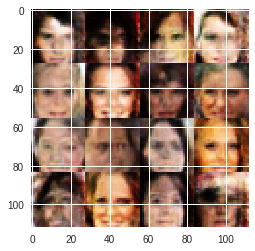

Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.6742
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.7918


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.